In [2]:
# !pip install git+https://github.com/yaledhlab/vggface.git
# !pip install keras_applications mtcnn

import keras_vggface
import mtcnn
import PIL
import os
import os.path
import keras_vggface.utils
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as mpl
from tensorflow.keras.utils import get_file
from keras_vggface.vggface import VGGFace

2023-10-26 13:58:00.257262: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 13:58:02.272981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


- VGG-16: It's a hefty 145 million parameters with a 500MB model file and is trained on a dataset of 2,622 people.
- ResNet50: It's 3x lighter at 41 million parameters with a 160MB model but can identify 4x the number of people at 8,631.
- SENet50: It's comparable to ResNet50 at 43 million parameters with a 170MB model and the same number of people, 8,631.

In [3]:
vggface = VGGFace(model="vgg16")
# vggface_resnet = VGGFace(model="resnet50")
# vggface_senet = VGGFace(model="senet50")

2023-10-26 13:58:09.583153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 13:58:10.176965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 13:58:10.177040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 13:58:10.181773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-26 13:58:10.181859: I tensorflow/compile

In [4]:
# print(vggface.summary())
# print("Inputs: ", vggface.inputs)
# print("Outputs: ", vggface.outputs)

In [5]:
from PIL import Image, ImageDraw

img = Image.open("unknown.jpg")
photo = np.array(img)
photo.shape

(600, 800, 3)

In [6]:
face_detector = mtcnn.MTCNN()

face_roi = face_detector.detect_faces(photo)

2023-10-26 13:58:29.707297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904


1/1 [==============================] - 1s 1s/step


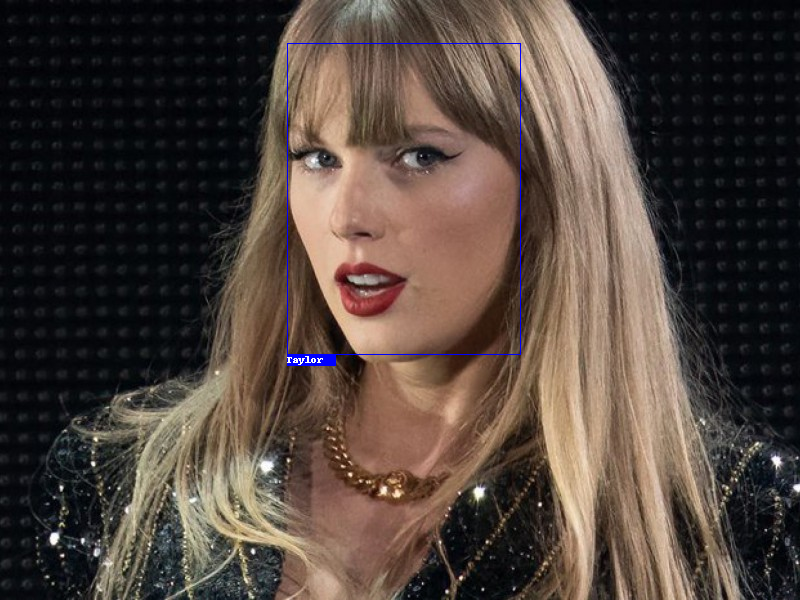

In [7]:
draw = ImageDraw.Draw(img)

left, top, width, height = face_roi[0]["box"]
right, bottom = left + width, top + height

draw.rectangle(((left, top), (right, bottom)), outline="blue")
text_left, text_top, text_right, text_bottom = draw.textbbox((left, bottom), "John Doe")
draw.rectangle(((text_left, text_top), (text_right, text_bottom)), fill="blue", outline="blue")
draw.text((text_left, text_top), "Taylor", fill="white")
img.show()

In [8]:
x1, y1, width, height = face_roi[0]["box"]
x2, y2 = x1 + width, y1 + height
face = photo[y1:y2, x1:x2]
face.shape

(311, 233, 3)

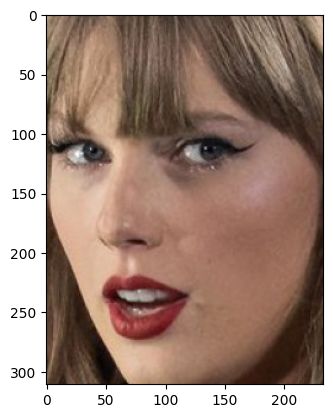

In [9]:
mpl.imshow(face)
mpl.show()

In [10]:
sample = np.resize(photo.reshape(1, photo.shape[0], photo.shape[1], 3), (1, 224, 224, 3))
predict = vggface.predict(sample)
predict, predict.shape


2023-10-26 13:58:51.997455: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-10-26 13:58:53.895852: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 3s 3s/step


(array([[0.00053734, 0.00110317, 0.00081039, ..., 0.00014859, 0.00167247,
         0.0010959 ]], dtype=float32),
 (1, 2622))

In [11]:
names = keras_vggface.utils.decode_predictions(predict)
names

[[["b'Austin_North'", 0.0032648277],
  ["b'Abigail_Breslin'", 0.0031445539],
  ["b'Riley_Steele'", 0.0031212687],
  ["b'Lavell_Crawford'", 0.0029867468],
  ["b'Taryn_Southern'", 0.0028977275]]]

In [12]:
import imghdr

# Remove Smelly images
whitelist = ("jpg", "jpeg", "png")
for root, paths, files in os.walk("training"):
    for name in files:
        filepath = os.path.join(root, name)
        img_type = imghdr.what(filepath)
        if img_type is None or img_type not in whitelist:
            print(f"{filepath} is a smelly image")
            os.remove(filepath)


In [13]:
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras


# Create dataset from disk
train_dataset = image_dataset_from_directory("training", shuffle=True, batch_size=8, image_size=(224, 224))

# Data Augment the images
data_augment = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2)
])

Found 1485 files belonging to 8 classes.


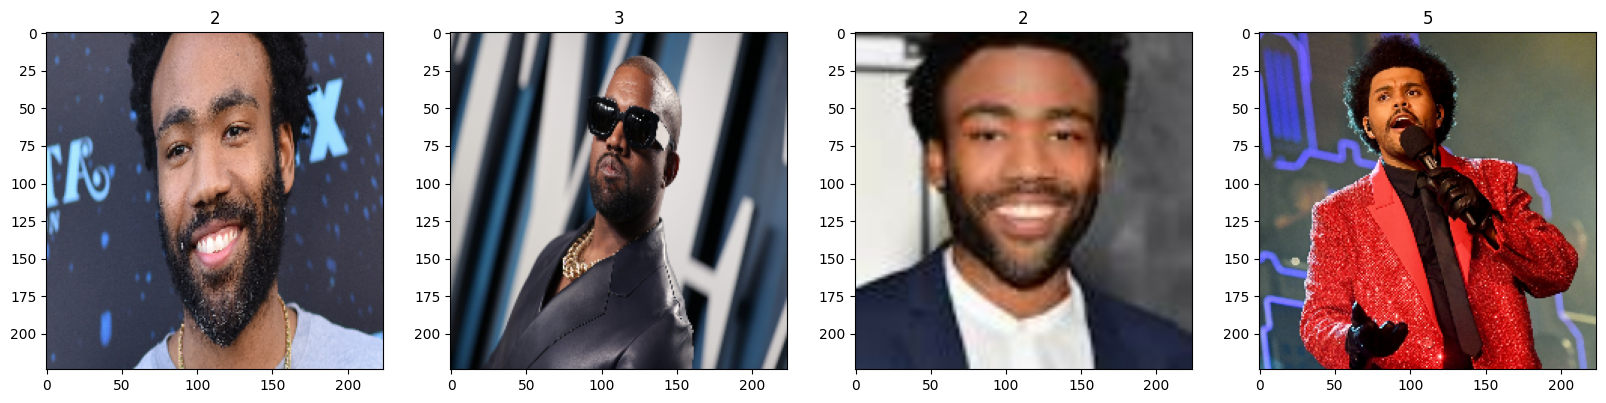

In [14]:
import matplotlib.pyplot as plt 

data = train_dataset.as_numpy_iterator()

batch = data.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [15]:
# Load the pretrained model
vggface_base = VGGFace(model="vgg16", include_top=False, input_shape=(224, 224, 3))

In [16]:
from keras.layers import Flatten, Dense, Input

# New classes to consider (people)
nb_class = len(os.listdir("training"))

# Freeze the pretrained model
vggface_base.trainable = False
last_layer = vggface_base.get_layer('pool5').output

# New model 
custom_vgg_model = tf.keras.Sequential([
    keras.Input(shape=(224, 224, 3)),
    data_augment,
    vggface_base,
    Flatten(name="flatten"),
    Dense(nb_class, name="classifier"),
    keras.layers.Softmax()
])

custom_vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 classifier (Dense)          (None, 8)                 200712    
                                                                 
 softmax_3 (Softmax)         (None, 8)                 0         
                                                                 
Total params: 14915400 (56.90 MB)
Trainable params: 200712 (784.03 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
base_lr = 0.0001

custom_vgg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=base_lr),
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=["accuracy"])

history = custom_vgg_model.fit(train_dataset, epochs=0)

In [18]:
ye_photo = np.array(Image.open("ibeknowin.jpg"))
print(ye_photo.shape)
ye_roi = face_detector.detect_faces(ye_photo);

x1, y1, width, height = ye_roi[0]["box"]
x2, y2 = x1 + width, y1 + height
face = ye_photo[y1:y2, x1:x2]
face.shape

mpl.imshow(face)
mpl.show()

(1080, 1080, 3)


1/1 [==============================] - 2s 2s/step


/home/breno/.local/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/home/breno/.local/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/home/breno/.local/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':
/home/breno/.local/lib/python3.10/site-packages/mtcnn/mtcnn.py:206: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if method is 'Min':


KeyboardInterrupt: 

In [ ]:
sample = np.resize(ye_photo.reshape(1, ye_photo.shape[0], ye_photo.shape[1], 3), (1, 224, 224, 3))
predictions = custom_vgg_model.predict(sample)
predictions

1/1 [==============================] - 0s 175ms/step


array([[0.16804244, 0.58842325, 0.00932612, 0.00482875, 0.01587248,
        0.04849432, 0.00815957, 0.15685311]], dtype=float32)

In [ ]:
photo = np.array(Image.open("floppa.jpg"))
print(photo.shape)
roi = face_detector.detect_faces(photo);

print(roi)

x1, y1, width, height = roi[0]["box"]
x2, y2 = x1 + width, y1 + height
face = photo[y1:y2, x1:x2]
face.shape

mpl.imshow(face)
mpl.show()


(1171, 1076, 3)
1/1 [==============================] - 1s 812ms/step
[]


IndexError: list index out of range